In [2]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def read_data(filepath: str, offset: int = 0, data_length: int = None, data_type: str ='int16') -> pd.DataFrame:
    """Фукнция для считывания данных из бинарных файлов

    Args:
        filepath (str): Путь до файла.
        offset (int, optional): Количество наблюдений, которое нужно пропустить сначала. Defaults to 0.
        data_length (int, optional): Необходимое количество наблюдений. Если не передавать никакого значения, будут считаны все данные, начиная с offset. Defaults to None.
        data_type (str, optional): Тип данных. Defaults to 'int16'.

    Returns:
        pd.DataFrame: Итоговая таблица. Столбцы right, top, left, bottom отвечают за данные с четырех пикапов.
    """

    # Считывание данных в один вектор
    line_data = np.fromfile(filepath, dtype=data_type)
    # Разделение вектора на четыре столбца матрицы, каждый из которых соответствует пикапу
    data = line_data.reshape(-1, 4)
    # Формирование датафрейма на основе предыдущей матрицы
    data = pd.DataFrame(data, columns=['right', 'top', 'left', 'bottom'])
    # Если не передано никакого значения в data_length, то будут браться все значение, начиная с offset
    if data_length is None: data_length = len(data) - offset
    # Из полученного датафрейма делается срез, начиная с offset, длинной data_length. в котором сбрасываются индесы (чтобы они начинались с нуля)
    data = data.iloc[offset: offset + data_length].reset_index().drop('index', axis=1)
    return data

In [9]:
def find_period_length_fft(data: np.ndarray, **kwargs) -> float:
    """Вычисление длины периода в заданном веторе данных.

    Args:
        data (np.ndarray): Вектор данных.
        **kwargs: Дополнительные ключевые аргументы - параметры для метода Фурье.
                Подробнее можно прочитать на https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fft.html#scipy-fft-fft

    Returns:
        float: Значение периода. Может получиться дробным.
    """

    # Применение прямого преобразования метода Фурье к данным
    yf = scipy.fft.fft(data, **kwargs)
    # Поиск индекса максимального значения в абсолютных величинах преобразованного вектора
    idx = np.argmax(np.abs(yf))
    # Нахождение длины периода, путем деления длины исходных данных на индекс максимального значения
    period = len(data)/idx
    return period

In [10]:
def get_beam_center_positions(summary_resonace: np.ndarray, difference_resonance: np.ndarray, period_length: float) -> np.ndarray:
    """Фукнция для вычисления координат центра масс по заданным суммарным и разностным резонансом для одной из осей.

    Args:
        summary_resonace (np.ndarray): Вектор суммарных резонансов по одной из осей.
        difference_resonance (np.ndarray): Вектор разностных резонансов по той же самой оси.
        period_length (float): Длина периода. Может быть дробной.

    Returns:
        np.ndarray: Вектор со значениями координаты центра масс для каждого из периодов по заданной оси.
    """

    # Вычисление общего количества периодов
    number_of_periods = int(len(summary_resonace) / period_length)
    # Задания вектора, с количеством элементов, равным числу периодов, для хранения полученных координат. Изначально заполнен нулями
    mass_center_positions = np.zeros(number_of_periods)
 
    # Запускаем цикл от 0 до number_of_periods-1 включительно с шагом 1. Грубо говоря, этим циклом мы пробегаемся по всем периодам
    for i in range(number_of_periods):

        # Находим срез, соответсвующий текущему периоду, для векторов summary_resonance и difference_resonance.
        # ВАЖНАЯ ДЕТАЛЬ. В данном случае, вручную задается тип int64, так как происходит переполнение изначального типа int16 при возведении значений в квадрат
        summary_resonance_period_slice = np.array(summary_resonace, 'int64')[int(i*period_length): int((i+1)*period_length)] 
        difference_resonance_period_slice = np.array(difference_resonance, 'int64')[int(i*period_length): int((i+1)*period_length)] 
 
        # Вычисление промежуточных параметров. Автор не особо осведомлен об их природе, поэтому тут могут потребоваться дополнительные пояснения
        m_11 = float(np.sum(summary_resonance_period_slice**2))
        m_12 = float(np.sum(summary_resonance_period_slice)) 
 
        y_1 = float(summary_resonance_period_slice @ difference_resonance_period_slice) 
        y_2 = float(np.sum(difference_resonance_period_slice)) 

        # Вычисление значения координаты центра масс для текущего периода. Добавление ее в итоговый вектор
        mass_center_positions[i] = ((m_12 * y_2) - (np.floor(period_length) * y_1)) / (m_12 ** 2 - m_11 * np.floor(period_length)) 
 
    return mass_center_positions

In [16]:
# WARNING!!! Данная функция пока еще не была протестирована для правой части спектра
def get_spectrum(beam_center_coordinates: np.ndarray, number_of_samples: int = 2**8, offset: int = 3, is_left_part: bool = True) -> tuple:
    """Функция для нахождения спектра дробной части бетатронной частоты.

    Args:
        beam_center_coordinates (np.ndarray): Вектор координат центров масс пучка по одной из осей.
        number_of_samples (int, optional): _description_. Число отсчетов для дискретного преобразования Фурье. Для корректной работы должно быть степенью двойки. Defaults to 2**8.
        offset (int, optional): _description_. Количество частот, которые мы пропускаем сначала (т.е. считаем их амплитуду нулевой). Defaults to 3.
        is_left_part (bool, optional): _description_. Флаг, отвечающий за интересующую часть спектра. Если True - берется левая часть спектра (частота меньше 0.5).
            Если False - правая (частота больше 0.5). Defaults to True.

    Returns:
        tuple: Возвращает кортеж с двумя векторами типов np.ndarray: frequences - значения частот, amplitudes - значения соответствующих им амплитуд.
    """

    # Применяем прямое преобразование Фурье для первый number_of_samples координат центров масс. Для получения нужной нормировки, делим на number_of_samples
    fourier_transformed_vector = scipy.fft.fft(np.array(beam_center_coordinates)[:number_of_samples]) / number_of_samples
    # Заполняем первые offset значений нулями и оставляем только первую половину значений от преобразованного вектора. В дальнейшем, если будет нужна правая часть, это преобразуется
    sliced_fourier_transformed_vector = np.concatenate([np.zeros(offset), fourier_transformed_vector[3: number_of_samples // 2]])
    # Находим амплитуды сигналов, находя абсолютные значения для каждой из величин преобразованного вектора
    amplitudes = np.abs(sliced_fourier_transformed_vector)

    # С помощью данного ветвления происходит выбор между правой и левой частями спектра
    if is_left_part:
        # Если левая часть спектра, то частоты берутся от 0 до 0.5
        frequences = np.arange(0, 0.5, 1 / number_of_samples)
    else:
        # WARNING!!! Данная часть не тестировалась. Возможные ошибки:
        # 1. Неправильный порядок частот или амплитуд. Можно попытаться отразить порядок следования элементов в массиве. Например, amplitudes = amplitudes[::-1].
        # 2. Небольшое смещение частот. Для этого, при расчете frequences нужно убрать слагаемое "+ 1 / number_of periods"

        # Если правая часть спектра, то сначала нужно преобразовать амплитуды
        amplitudes = 1 - amplitudes
        # Частоты берутся от 0.5 до 1
        frequences = np.arange(0.5, 1, 1 / number_of_samples) + 1 / number_of_samples

    return frequences, amplitudes

In [ ]:
def find_main_frequence(frequences, amplitudes, slice_percentage=1) -> :
    main_frequence_index = np.argmax(amplitudes[:int(slice_percentage * 2 * len(frequences))])
    main_frequence = frequences[main_frequence_index]
    return main_frequence

In [14]:
sns.set_theme()

In [5]:
offset = 8 * 6300 // 2 // 4
len_data = 4 * 1024**2 // 4

In [6]:
data = read_data(r'bpm_data/11_01_booster_libera08_hbpm3_1_full', offset=offset, data_length=len_data)
data

,right,top,left,bottom
0,-147,-273,-406,79
1,-157,-196,-416,321
2,17,-124,-416,383
3,373,-29,-415,230
4,247,-82,-421,-149
...,...,...,...,...
1048571,496,365,32,438
1048572,526,141,228,682
1048573,614,271,132,356
1048574,486,376,130,-11


In [7]:
summary_resonance = pd.DataFrame()
summary_resonance['X'] = data['right'] + data['left']
summary_resonance['Y'] = data['top'] + data['bottom']

difference_resonance = pd.DataFrame()
difference_resonance['X'] = data['right'] - data['left']
difference_resonance['Y'] = data['top'] - data['bottom']

In [11]:
period = find_period_length_fft(summary_resonance['X'])
period

2126.9290060851927

In [12]:
plate_size = {}
plate_size['X'] = 64
plate_size['Y'] = 33

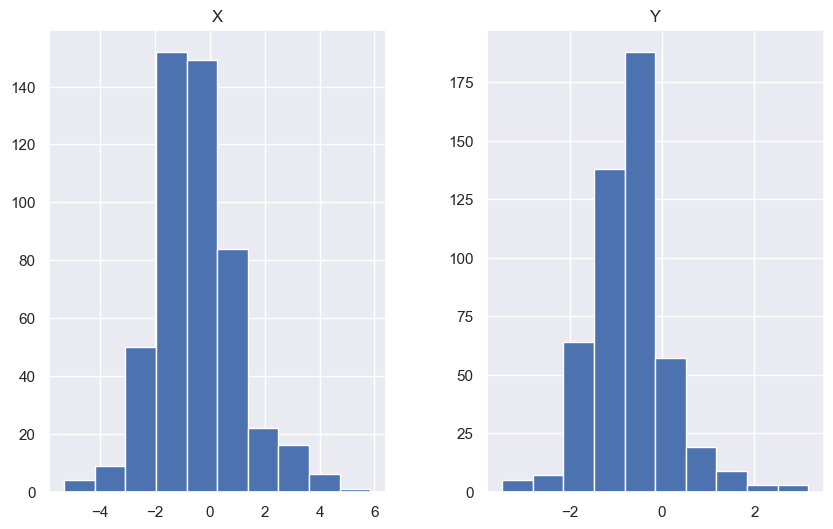

In [15]:
beam_center_coords = pd.DataFrame()
for axis in ['X', 'Y']:
    beam_center_coords[axis] = plate_size[axis] * get_beam_center_positions(summary_resonance[axis], difference_resonance[axis], period)
beam_center_coords.hist(figsize = (10, 6));